In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
%matplotlib inline

In [2]:
import collections

In [3]:
import seaborn as sns

In [4]:
sns.set()

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
f = open("chess/out.chess")

In [7]:
f.readline()

'% asym multisigned\n'

In [8]:
G = nx.MultiDiGraph()

In [9]:
edges = []
timestamps = []
weights = []
for line in f:
    x = line.split()
    G.add_edge(x[0], x[1], weight=int(x[2]), timestamp=float(x[3]))
    edges.append((x[0], x[1]))
    weights.append(int(x[2]))
    timestamps.append(float(x[3]))

In [10]:
f.close()

#### Компоненты связности

In [11]:
len(list(G.nodes()))

7301

In [12]:
len(list(G.edges()))

65053

In [13]:
nx.is_connected(G.to_undirected())

False

In [14]:
comps = [c for c in sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)]

In [15]:
for comp in comps:
    print(len(comp), end=' ')

7115 7 6 5 5 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [16]:
for comp in comps:
    G_ = G.subgraph(comp)
    print(len(list(G_.edges())), end=' ')

64926 11 7 4 5 3 3 4 3 3 2 2 2 2 3 4 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1 

Реально, почти вся информация в одной компоненте связности.

In [17]:
G = G.subgraph(comps[0])

In [18]:
len(list(G.nodes()))

7115

In [19]:
len(list(G.edges()))

64926

#### Распределение степеней

In [20]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

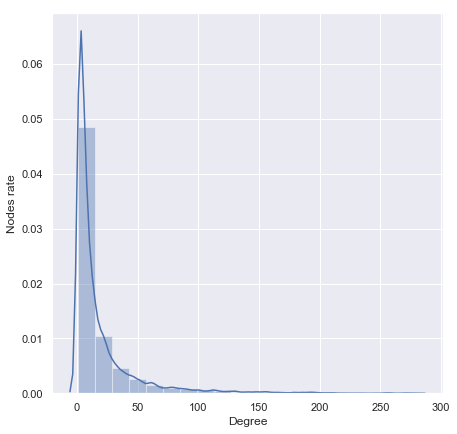

In [21]:
plt.figure(figsize=(7,7))
_ = sns.distplot(degree_sequence, bins=20)
plt.xlabel("Degree")
plt.ylabel("Nodes rate")
plt.savefig("degree.pdf")

In [22]:
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)

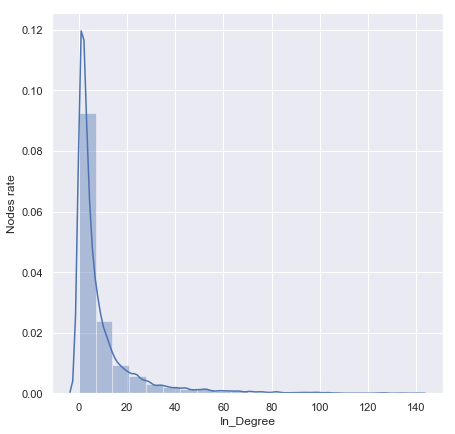

In [23]:
plt.figure(figsize=(7,7))
_ = sns.distplot(in_degree_sequence, bins=20)
plt.xlabel("In_Degree")
plt.ylabel("Nodes rate")
plt.savefig("degree_in.pdf")

In [24]:
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)

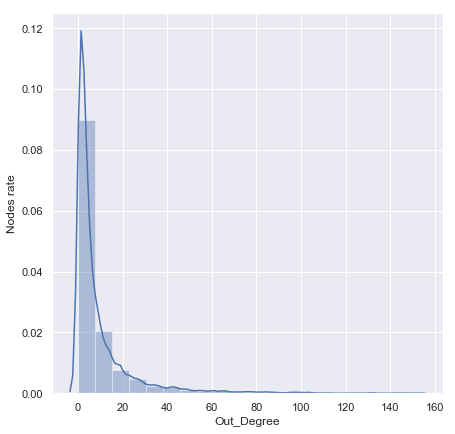

In [25]:
plt.figure(figsize=(7,7))
_ = sns.distplot(out_degree_sequence, bins=20)
plt.xlabel("Out_Degree")
plt.ylabel("Nodes rate")
plt.savefig("degree_out.pdf")

#### Модель малого мира

In [20]:
G_ = G.to_undirected()

In [27]:
nodes = list(G_.nodes())

In [52]:
from tqdm import tqdm

In [53]:
d = collections.defaultdict(int)
for i in tqdm(range(len(nodes))):
    for j in range(i + 1, len(nodes)):
        x = nx.shortest_path_length(G_, source=nodes[i], target=nodes[j])
        d[x] += 1

100%|██████████| 7115/7115 [35:06<00:00,  3.38it/s]


In [54]:
d

defaultdict(int,
            {1: 55779,
             2: 1184701,
             3: 6950816,
             4: 10011625,
             5: 5094235,
             6: 1516817,
             7: 380233,
             8: 89956,
             9: 19818,
             10: 3513,
             11: 492,
             12: 64,
             13: 6})

In [71]:
p = np.array(list(d.values()))
dist = np.array(list(d.keys()))

Средняя длина пути между вершинами.

In [78]:
(p * dist).sum() / p.sum()

4.010471567253983

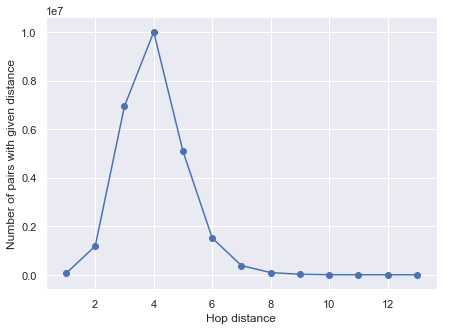

In [65]:
plt.figure(figsize=(7,5))
plt.plot(list(d.keys()), list(d.values()))
plt.scatter(list(d.keys()), list(d.values()))
plt.xlabel("Hop distance")
plt.ylabel("Number of pairs with given distance")
plt.savefig("hop_distance.pdf")

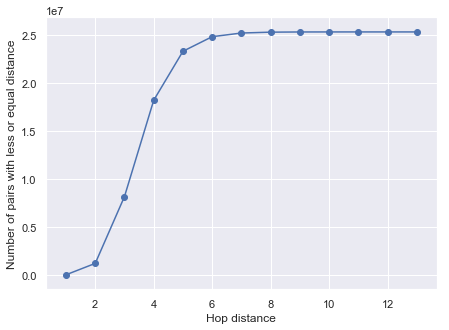

In [83]:
plt.figure(figsize=(7,5))
plt.plot(dist, p.cumsum())
plt.scatter(dist, p.cumsum())
plt.xlabel("Hop distance")
plt.ylabel("Number of pairs with less or equal distance")
plt.savefig("hop_distance_cum.pdf")

#### Коэффициент кластеризации

In [21]:
_G_ = nx.Graph()
for u,v in G_.edges():
    _G_.add_edge(u, v)

Глобальный коэффициент

In [100]:
nx.transitivity(_G_)

0.1258356478709473

Среднее по локальным коэффициентам

In [102]:
nx.average_clustering(_G_)

0.17939575805920835

#### Разреженность

In [113]:
len(G.nodes())

7115

Средняя степень вершины в мультиграфе

In [112]:
np.mean(list(dict(G.degree()).values()))

18.250456781447646

Не в мультиграфе

In [114]:
np.mean(list(dict(_G_.degree()).values()))

15.679269149683767

#### Поиск сообществ

In [64]:
coms = nx.algorithms.community.label_propagation_communities(G_)

In [65]:
c = []
lengths = []
for com in coms:
    if len(com) > 100:
        c.append(com)
    lengths.append(len(com))

In [66]:
len(c)

2

In [74]:
x, y = np.unique(lengths, return_counts=True)

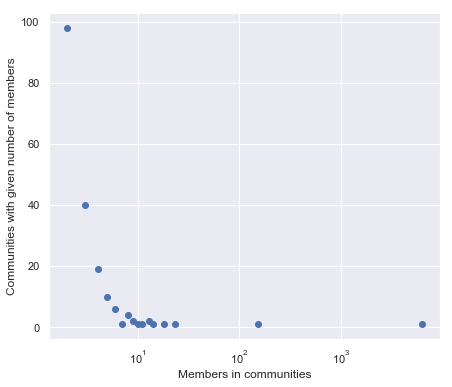

In [81]:
plt.figure(figsize=(7,6))
plt.scatter(x, y)
plt.xscale('log')
plt.xlabel('Members in communities')
plt.ylabel('Communities with given number of members')
plt.savefig('community_scatter.pdf')

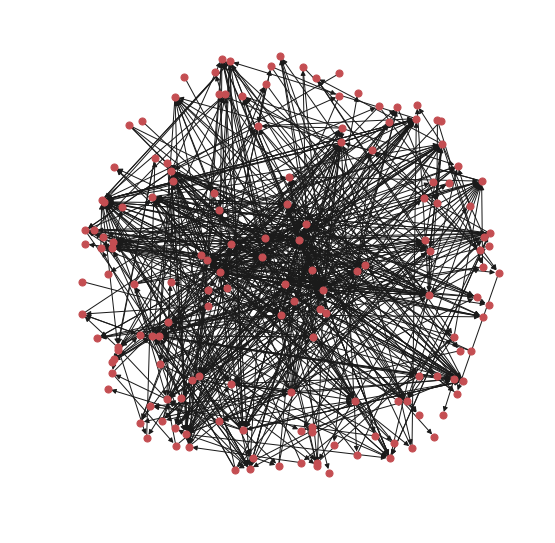

In [60]:
plt.figure(figsize=(7,7))
nx.draw(G.subgraph(c[0]), node_size=50)
plt.savefig("community_1.pdf")

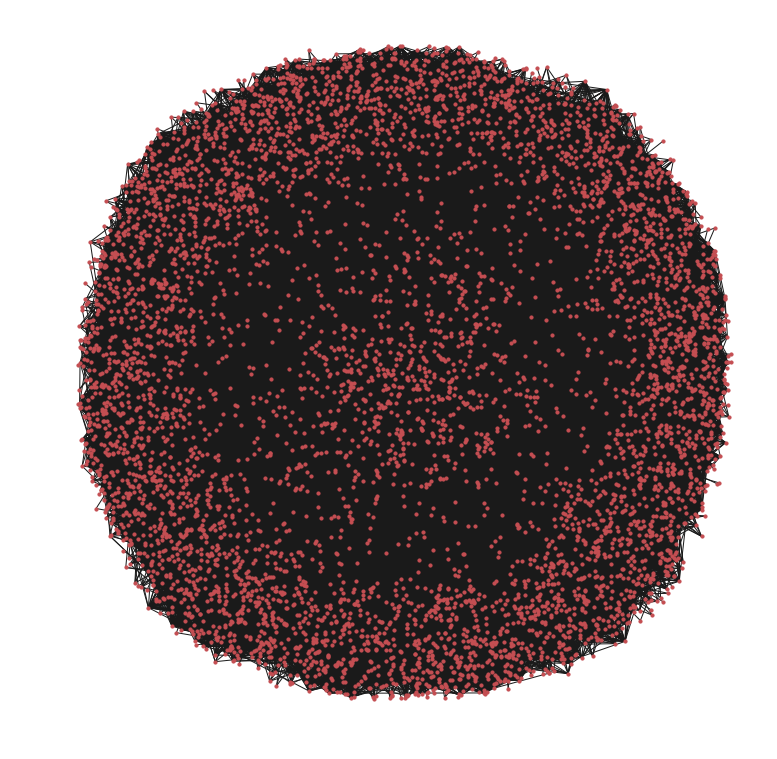

In [59]:
plt.figure(figsize=(10,10))
nx.draw(G_.subgraph(c[1]), node_size=10)
plt.savefig("community_2.pdf")

In [126]:
coms = nx.algorithms.community.label_propagation_communities(G_.subgraph(c[1]))

In [127]:
c_new = []
lengths = []
for com in coms:
    if len(com) > 100:
        c_new.append(com)
    lengths.append(len(com))

In [129]:
len(c_new)

1

In [130]:
len(c_new[0])

6310

In [131]:
coms = nx.algorithms.community.label_propagation_communities(G_.subgraph(c_new[0]))

In [132]:
c_new = []
lengths = []
for com in coms:
    if len(com) > 100:
        c_new.append(com)
    lengths.append(len(com))

In [136]:
len(c_new[0])

6310

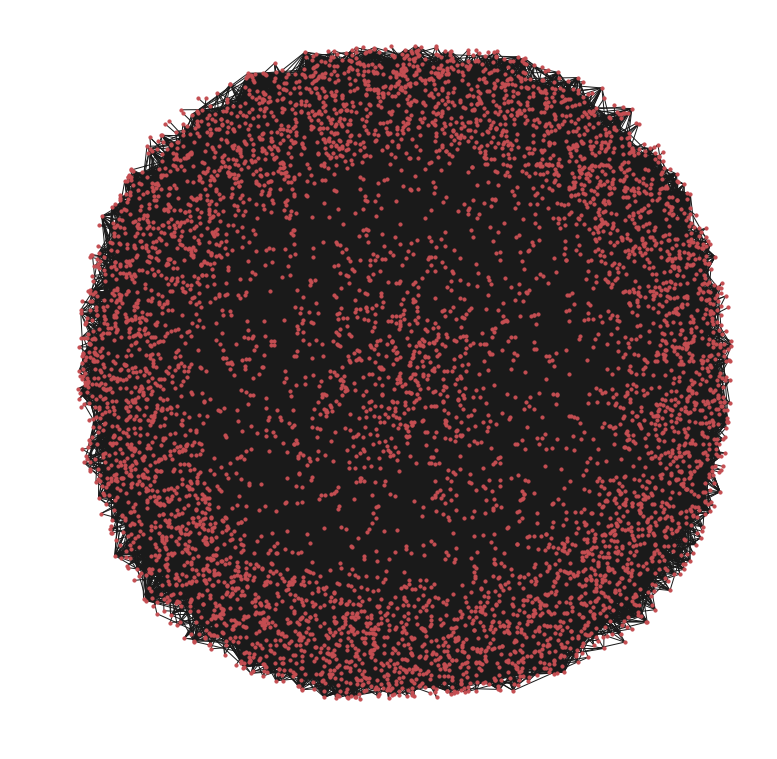

In [63]:
plt.figure(figsize=(10,10))
nx.draw(G_.subgraph(c[0] | c[1]), node_size=10)
plt.savefig("community_mished.pdf")

#### Центральность вершин

In [82]:
d = nx.degree_centrality(G)

In [83]:
deg = np.array(list(d.values()))
nod_deg = np.array(list(d.keys()))

In [84]:
ind = deg.argsort()

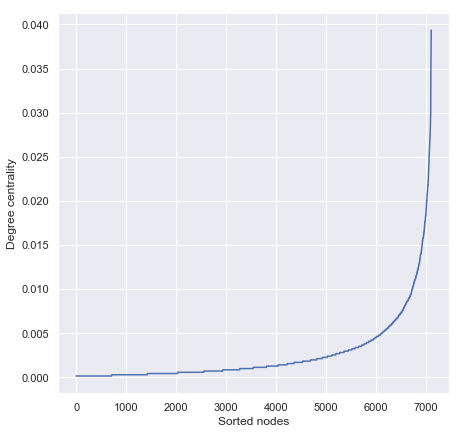

In [85]:
plt.figure(figsize=(7,7))
plt.plot(deg[ind])
plt.ylabel("Degree centrality")
plt.xlabel("Sorted nodes")
plt.savefig("Degree_centrality.pdf")

In [91]:
pos = nx.spring_layout(G)

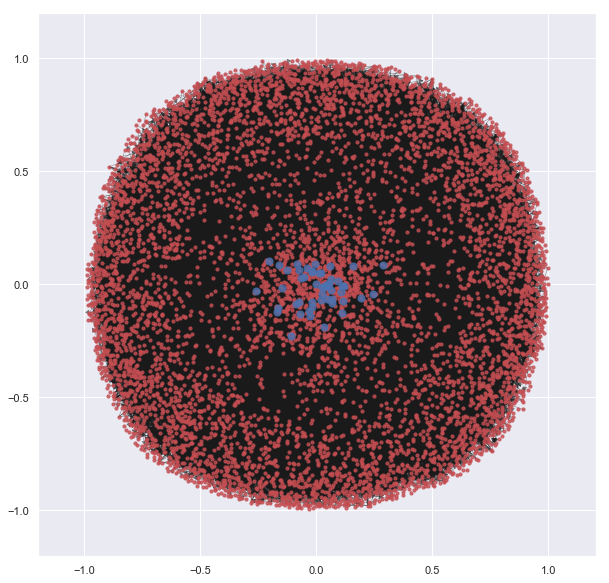

In [116]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(G.nodes()),
                       node_color='r',
                       node_size=10,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(nod_deg[ind][-50:]),
                       node_color='b',
                       node_size=50,
                   alpha=0.8)

nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
plt.savefig("Centrality_points.pdf")

In [17]:
d = nx.closeness_centrality(G)

In [19]:
close = np.array(list(d.values()))
nod_close = np.array(list(d.keys()))

In [20]:
ind_close = close.argsort()

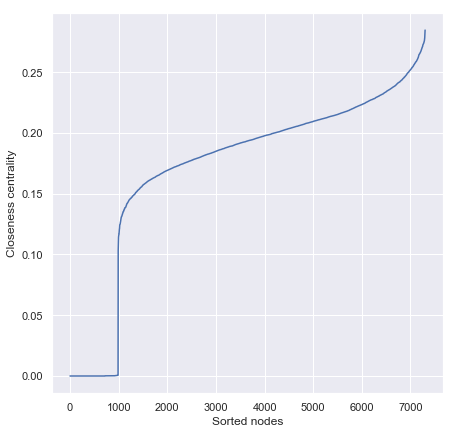

In [22]:
plt.figure(figsize=(7,7))
plt.plot(close[ind_close])
plt.ylabel("Closeness centrality")
plt.xlabel("Sorted nodes")
plt.savefig("Close_centrality.pdf")

In [108]:
d = nx.eigenvector_centrality(_G_)

In [109]:
eigen = np.array(list(d.values()))
nod_eigen = np.array(list(d.keys()))

In [110]:
ind_eigen = eigen.argsort()

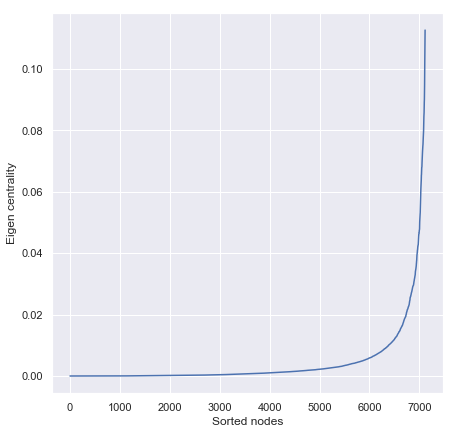

In [111]:
plt.figure(figsize=(7,7))
plt.plot(eigen[ind_eigen])
plt.ylabel("Eigen centrality")
plt.xlabel("Sorted nodes")
plt.savefig("Eigen_centrality.pdf")

In [114]:
pos = nx.spring_layout(G)

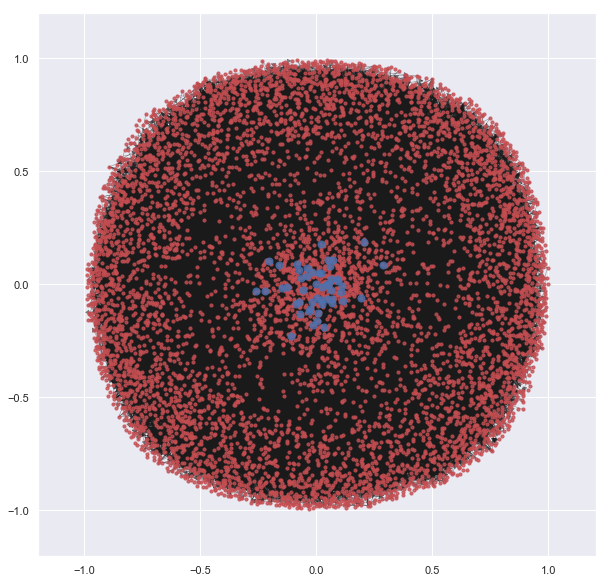

In [117]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(G.nodes()),
                       node_color='r',
                       node_size=10,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=list(nod_eigen[ind_eigen][-50:]),
                       node_color='b',
                       node_size=50,
                   alpha=0.8)

nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
plt.savefig("Centrality_points_eigen.pdf")

In [33]:
d = nx.betweenness_centrality(_G_)

In [34]:
betw = np.array(list(d.values()))
nod_betw = np.array(list(d.keys()))

In [35]:
ind_betw = betw.argsort()

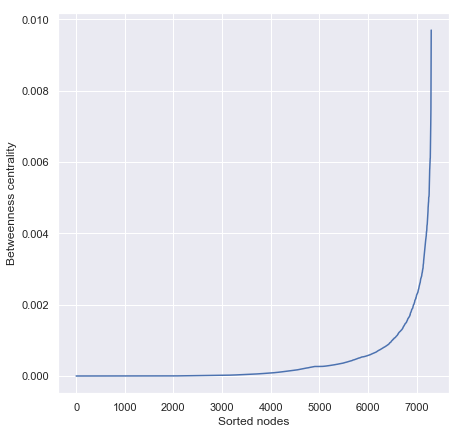

In [36]:
plt.figure(figsize=(7,7))
plt.plot(betw[ind_betw])
plt.ylabel("Betweenness centrality")
plt.xlabel("Sorted nodes")
plt.savefig("Betweenness_centrality.pdf")